# NeuralProphet

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

In [3]:
#pip install plotly==5.6.0

In [2]:
from neuralprophet.benchmark import Dataset, NeuralProphetModel, SimpleExperiment, CrossValidationExperiment

WARNING - (NP.benchmark.<module>) - Benchmarking Framework is not covered by tests. Please report any bugs you find.If you use multiprocessing, only run one benchmark per python script.


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from neuralprophet import NeuralProphet, set_log_level
import pickle
set_log_level("ERROR")

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.rcParams.update({'figure.facecolor':'white'})

## Modelling for Northern Hemisphere

In [4]:
df_NH = pd.read_csv('data/NH_modelling.csv')
df_NH.head(2)

,date,Extent
0,1978-10-26,10.231
1,1978-10-28,10.420


In [5]:
#df_NH['Extent'] *=1000000

In [6]:
df_NH.tail(2)

,date,Extent
14181,2022-03-03,14.703
14182,2022-03-04,14.748


In [7]:
df_NH['date'] = pd.to_datetime(df_NH['date'])

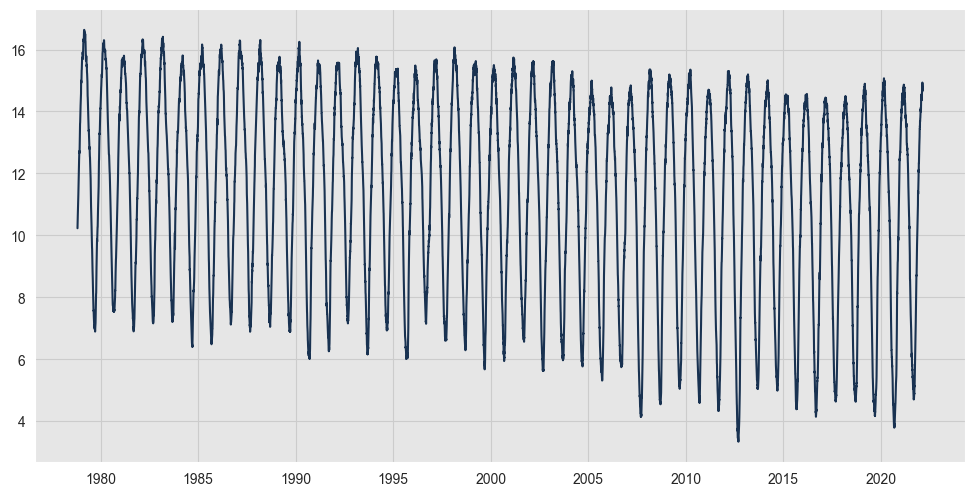

In [8]:
plt.plot(df_NH['date'], df_NH['Extent'])
plt.show()

In [9]:
df_NH = df_NH[['date', 'Extent']]
df_NH.dropna(inplace=True)
df_NH.columns = ['ds', 'y']

In [10]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_NH, freq="MS", valid_p=0.136)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.00081,0.385127,0.467064


In [11]:
df_train

,ds,y
0,1978-10-26,10.231
1,1978-10-28,10.420
2,1978-10-30,10.557
3,1978-11-01,10.670
4,1978-11-03,10.777
...,...,...
12250,2016-11-16,8.804
12251,2016-11-17,8.698
12252,2016-11-18,8.585
12253,2016-11-19,8.584


In [12]:
df_test

,ds,y
0,2016-11-21,8.900
1,2016-11-22,8.989
2,2016-11-23,9.058
3,2016-11-24,9.188
4,2016-11-25,9.291
...,...,...
1923,2022-02-28,14.671
1924,2022-03-01,14.693
1925,2022-03-02,14.765
1926,2022-03-03,14.703


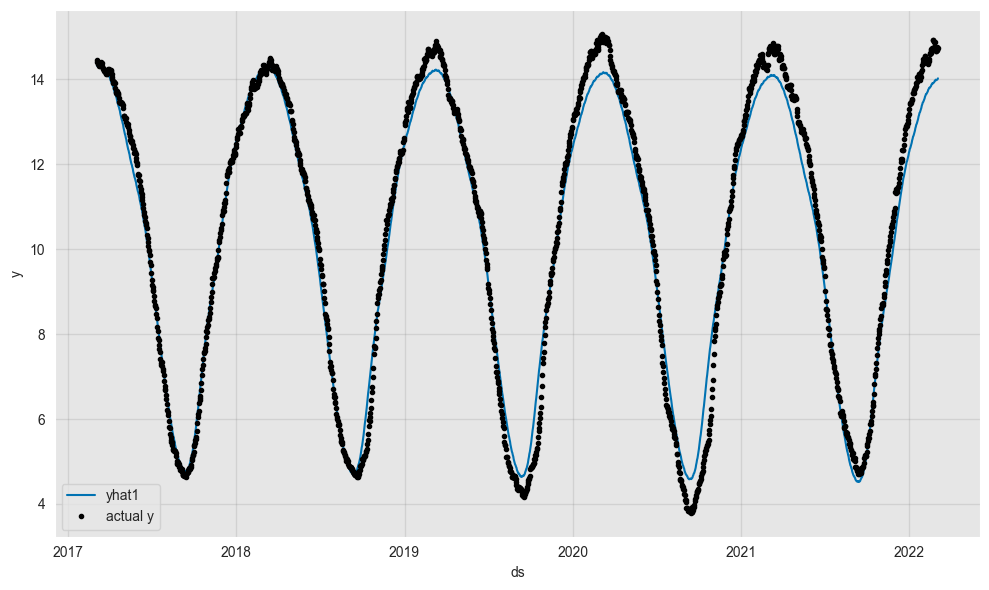

In [13]:
#metrics_train2 = m.fit(df=df_NH, freq="MS")
future_NH = m.make_future_dataframe(df_NH, periods=0, n_historic_predictions=365*5)
forecast_NH = m.predict(future_NH)
fig = m.plot(forecast_NH)

In [14]:
forecast_NH.head()

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2017-03-04,14.404,14.325061,-0.078939,10.369958,3.949647,0.005455
1,2017-03-05,14.449,14.340748,-0.108252,10.369793,3.954989,0.015966
2,2017-03-06,14.417,14.322589,-0.094411,10.369626,3.959459,-0.006496
3,2017-03-07,14.365,14.324990,-0.040010,10.369460,3.963009,-0.007478
4,2017-03-08,14.326,14.327364,0.001364,10.369295,3.965590,-0.007521


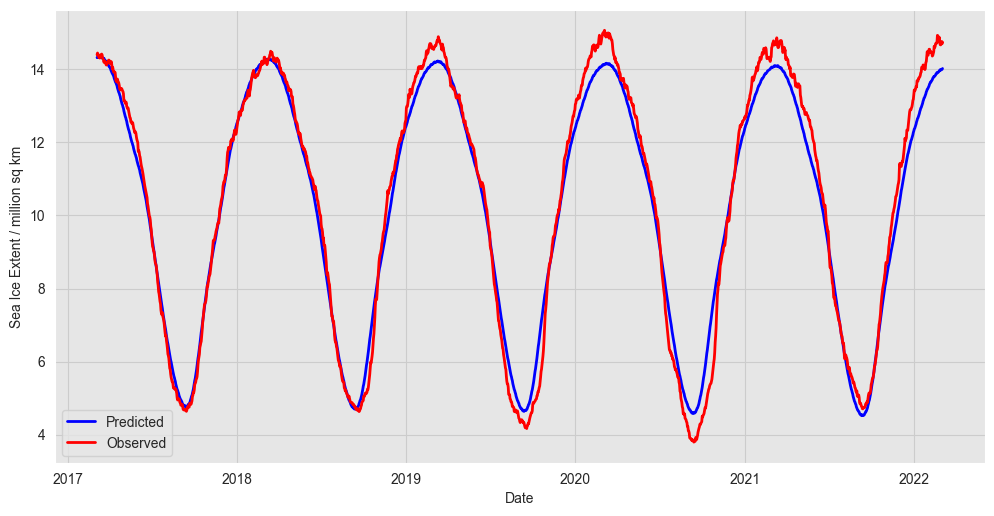

In [15]:
plt.plot(forecast_NH['ds'], forecast_NH['yhat1'], color='blue', linewidth=2, label='Predicted')
plt.plot(forecast_NH['ds'], forecast_NH['y'], color='red', linewidth=2, label='Observed')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent / million sq km')
plt.legend()
#plt.xticks(monthList)
#plt.title('Predicted Sea Ice for Northern Hemisphere')

plt.savefig('images/Forecast_NH_1.png', dpi=300)
plt.show()

## Residual Plot

In [16]:
forecast_NH

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2017-03-04,14.404,14.325061,-0.078939,10.369958,3.949647,0.005455
1,2017-03-05,14.449,14.340748,-0.108252,10.369793,3.954989,0.015966
2,2017-03-06,14.417,14.322589,-0.094411,10.369626,3.959459,-0.006496
3,2017-03-07,14.365,14.324990,-0.040010,10.369460,3.963009,-0.007478
4,2017-03-08,14.326,14.327364,0.001364,10.369295,3.965590,-0.007521
...,...,...,...,...,...,...,...
1820,2022-02-28,14.671,13.979565,-0.691435,10.067819,3.918242,-0.006496
1821,2022-03-01,14.693,13.986978,-0.706022,10.067654,3.926803,-0.007478
1822,2022-03-02,14.765,13.994640,-0.770360,10.067488,3.934673,-0.007521
1823,2022-03-03,14.703,13.999579,-0.703421,10.067322,3.941813,-0.009555


In [17]:
df_residual = forecast_NH[['ds','y','yhat1','residual1']]

In [18]:
df_residual['y']

0       14.404
1       14.449
2       14.417
3       14.365
4       14.326
         ...  
1820    14.671
1821    14.693
1822    14.765
1823    14.703
1824    14.748
Name: y, Length: 1825, dtype: float64

In [19]:
df_residual

,ds,y,yhat1,residual1
0,2017-03-04,14.404,14.325061,-0.078939
1,2017-03-05,14.449,14.340748,-0.108252
2,2017-03-06,14.417,14.322589,-0.094411
3,2017-03-07,14.365,14.324990,-0.040010
4,2017-03-08,14.326,14.327364,0.001364
...,...,...,...,...
1820,2022-02-28,14.671,13.979565,-0.691435
1821,2022-03-01,14.693,13.986978,-0.706022
1822,2022-03-02,14.765,13.994640,-0.770360
1823,2022-03-03,14.703,13.999579,-0.703421


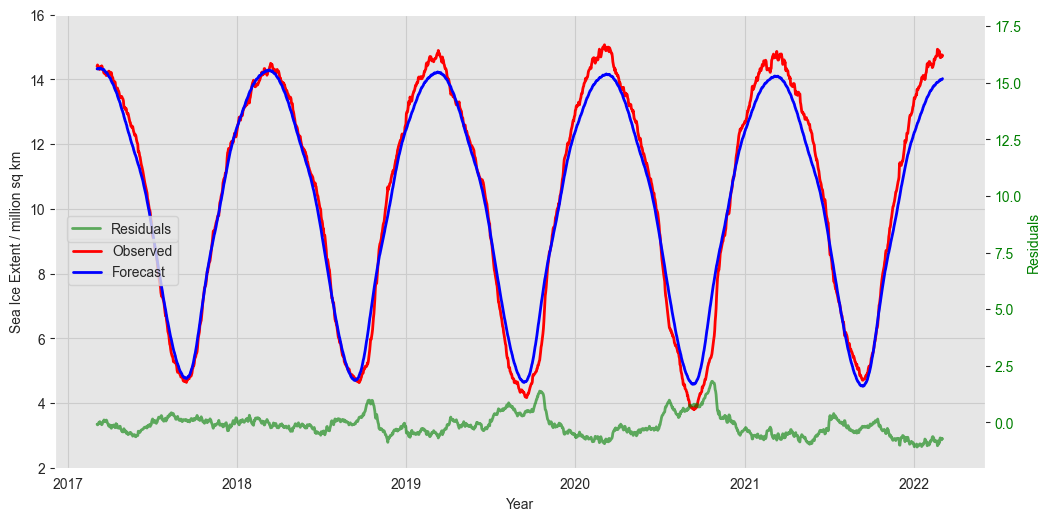

In [159]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x='ds', y='residual1', data=df_residual, color='green', label='Residuals', linewidth=2, ax=ax2, alpha=0.6)
sns.lineplot(x='ds', y='y', data=df_residual, color='red', label='Observed', linewidth=2, ax=ax1)
sns.lineplot(x='ds', y='yhat1', data=df_residual, color='blue', label='Forecast', linewidth=2, ax=ax1)
ax1.legend(bbox_to_anchor=(0.14, .52))
ax2.legend(bbox_to_anchor=(0.14, 0.57))
ax1.tick_params(axis='y')
ax1.set_ylabel('Sea Ice Extent / million sq km')
ax1.set_xlabel('Year')
#ax1.set('Sea Ice Extent')
ax2.set_ylim(-2,18)
ax1.set_ylim(2,16)
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel('Residuals', fontdict={'color': 'green'});
fig.savefig('images/NH_residuals.png', dpi=300)

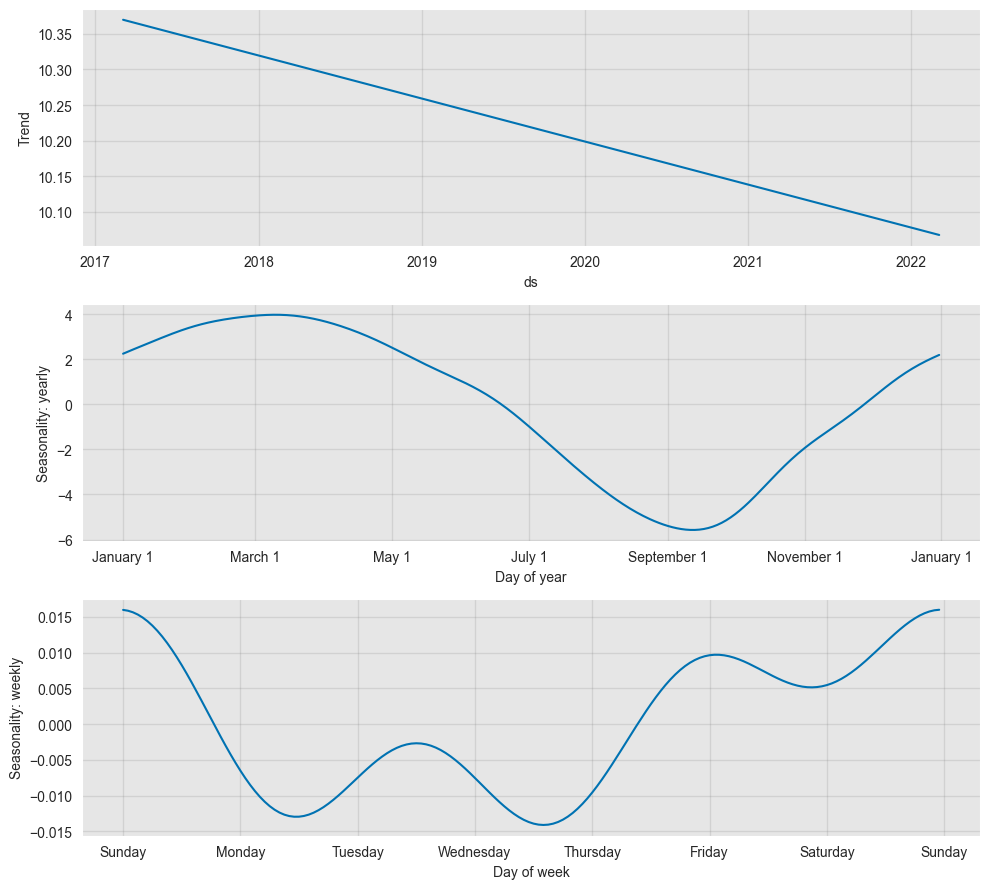

In [21]:
fig2 = m.plot_components(forecast_NH)

# Future Prediction for Northern Hemisphere

In [22]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_NH, freq="MS", valid_p=0.136)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.000812,0.384652,0.467773


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



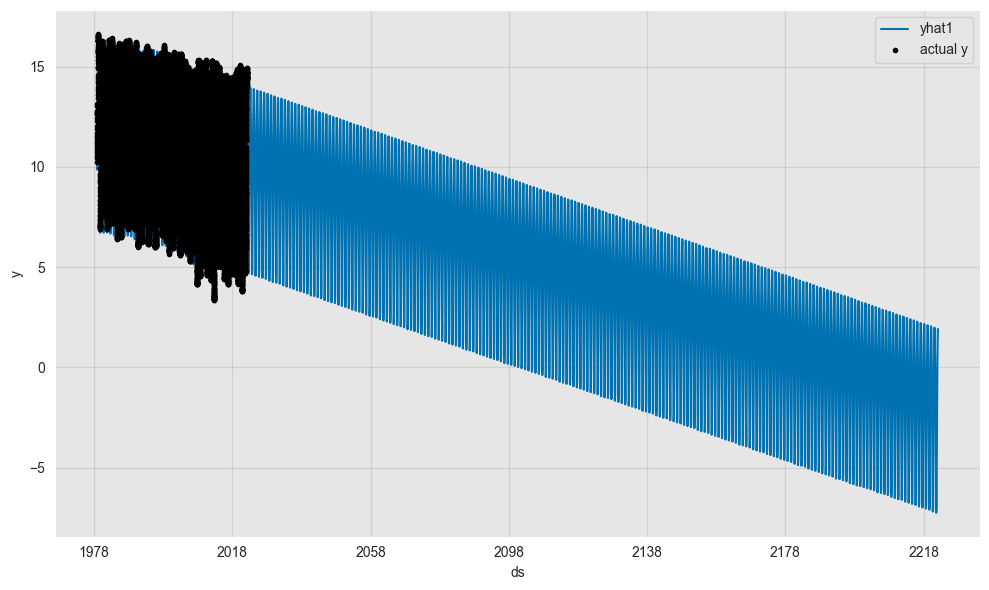

In [23]:
#metrics_train2 = m.fit(df=df_NH, freq="MS")
future_NHF = m.make_future_dataframe(df_NH, periods=24*100, n_historic_predictions=365*39)
forecast_NHF = m.predict(future_NHF)
fig = m.plot(forecast_NHF)

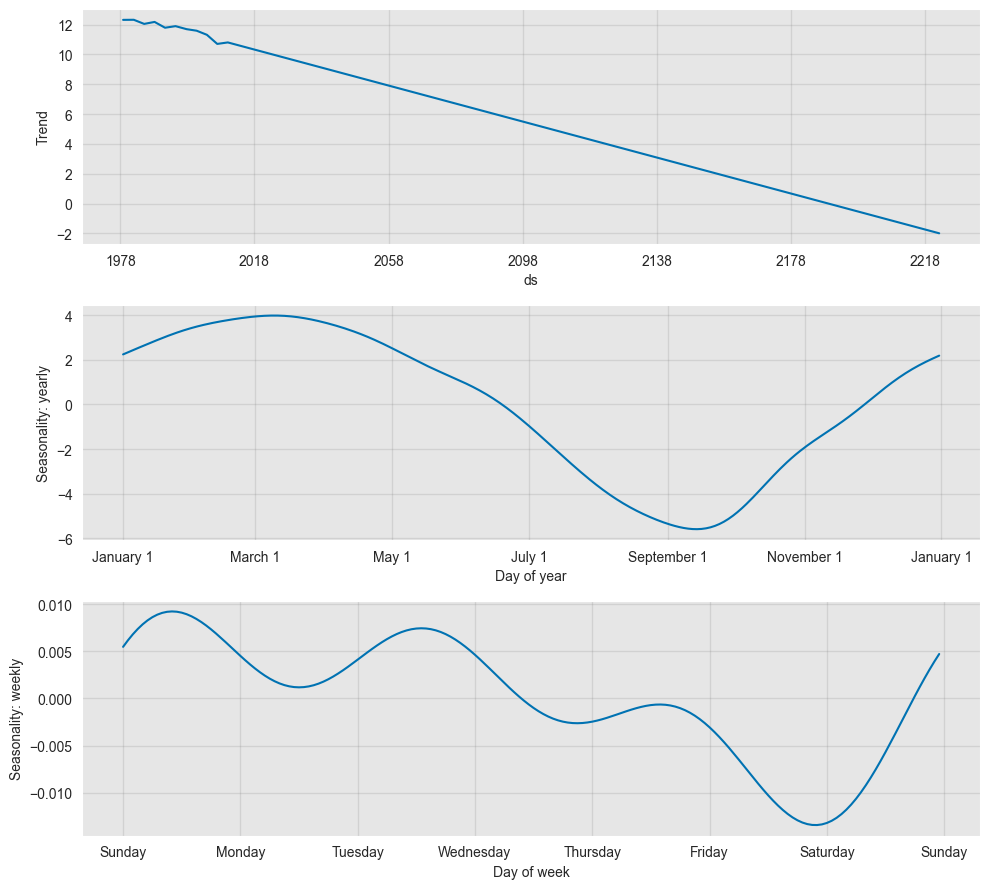

In [24]:
fig2 = m.plot_components(forecast_NHF)

### Prediction till 20125

In [67]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_NH, freq="MS", valid_p=0.136)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.00084,0.39399,0.476356


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



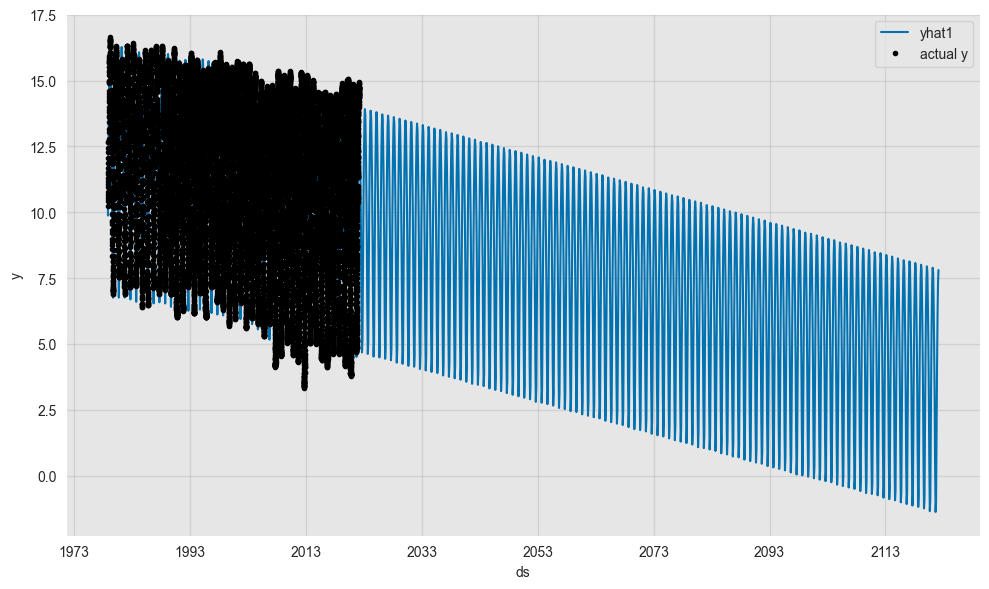

In [69]:
future_NHF1 = m.make_future_dataframe(df_NH, periods=24*50, n_historic_predictions=365*39)
forecast_NHF1 = m.predict(future_NHF1)
fig = m.plot(forecast_NHF1)

In [70]:
forecast_NHF1

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,1978-10-26,10.231,9.873932,-0.357068,12.327579,-2.455253,0.001607
1,1978-10-28,10.42,10.053912,-0.366088,12.327564,-2.281093,0.007440
2,1978-10-30,10.557,10.215694,-0.341306,12.327551,-2.114930,0.003073
3,1978-11-01,10.67,10.372646,-0.297354,12.327538,-1.956329,0.001438
4,1978-11-03,10.777,10.520009,-0.256991,12.327523,-1.804492,-0.003022
...,...,...,...,...,...,...,...
15378,2121-11-01,None,1.933800,NaN,3.941321,-2.014961,0.007440
15379,2121-12-01,None,4.130409,NaN,3.936275,0.191060,0.003073
15380,2122-01-01,None,6.108006,NaN,3.931060,2.175338,0.001607
15381,2122-02-01,None,7.316729,NaN,3.925845,3.406877,-0.015994


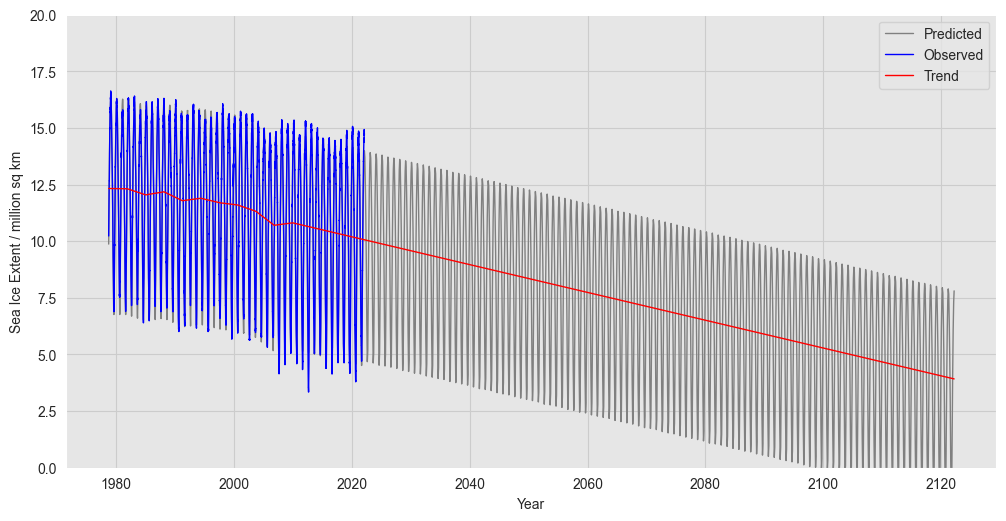

In [158]:
plt.plot(forecast_NHF1['ds'], forecast_NHF1['yhat1'], color='grey', linewidth=1, label='Predicted')
plt.plot(forecast_NHF1['ds'], forecast_NHF1['y'], color='blue', linewidth=1, label='Observed')
plt.plot(forecast_NHF1['ds'], forecast_NHF1['trend'], color='red', linewidth=1, label='Trend')
plt.xlabel('Year')
plt.ylabel('Sea Ice Extent / million sq km')
plt.legend()
plt.ylim(0,20)
#plt.xticks(monthList)
#plt.title('Predicted Sea Ice for Northern Hemisphere')

plt.savefig('images/Forecast_NH_F_100.png', dpi=300)
plt.show()

In [29]:
#making a new column with mean of other column
#df_plot['yhat1_mean'] = df_plot.groupby(df_plot.date.dt.year)['yhat1'].transform('mean')

# Making the dataset for future prediction

In [63]:
#forecast_NHF.to_csv('data/NH_forecast_corrected.csv', index=False)

## Modelling for Central Arctic

In [33]:
df_CA = pd.read_csv('data/Central_Arctic_from_masie.csv')

In [34]:
df_CA.head(2)

,date,Central_Arctic
0,01-01-2006,3225371.74
1,01-02-2006,3225371.74


In [35]:
df_CA['Central_Arctic'] /= 1000000

In [36]:
df_CA.head(2)

,date,Central_Arctic
0,01-01-2006,3.225372
1,01-02-2006,3.225372


In [37]:
df_CA['date'] = pd.to_datetime(df_CA['date'])

In [38]:
df_CA = df_CA[['date', 'Central_Arctic']]
df_CA.dropna(inplace=True)
df_CA.columns = ['ds', 'y']

In [39]:
df_CA.head(2)

,ds,y
0,2006-01-01,3.225372
1,2006-01-02,3.225372


In [40]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_CA, freq="MS", valid_p=0.23)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.012678,0.059984,0.096468


In [41]:
df_train

,ds,y
0,2006-01-01,3.225372
1,2006-01-02,3.225372
2,2006-01-03,3.240508
3,2006-01-04,3.240326
4,2006-01-05,3.240326
...,...,...
4512,2018-06-22,3.071422
4513,2018-06-23,3.072899
4514,2018-06-24,3.077773
4515,2018-06-25,3.064234


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



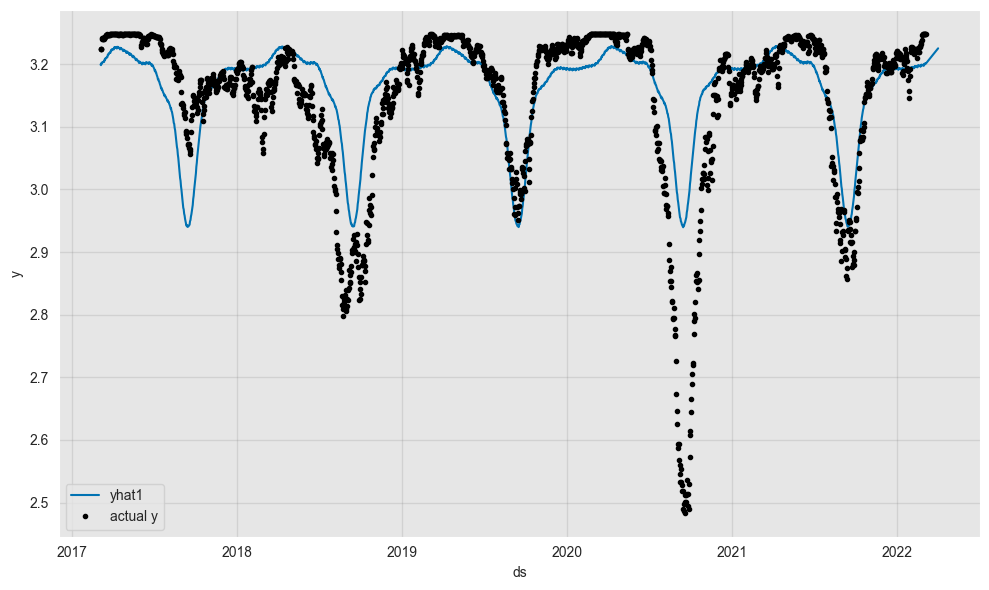

In [42]:
#metrics_train2 = m.fit(df=df_NH, freq="MS")
future = m.make_future_dataframe(df_CA, periods=1, n_historic_predictions=365*5)
forecast_2 = m.predict(future)
fig = m.plot(forecast_2)

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

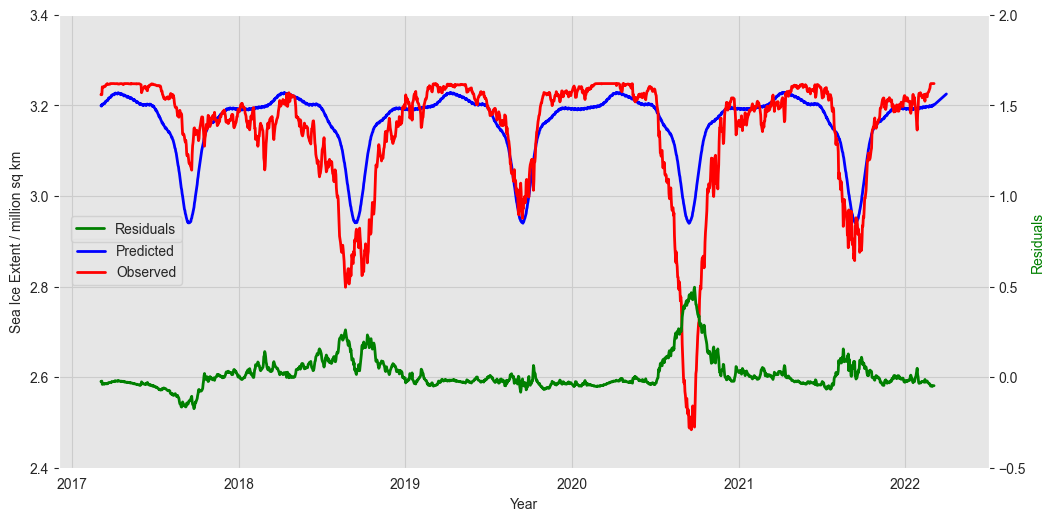

In [161]:


fig = plt.figure()

ax = fig.add_subplot(111)
plt.grid()
ax.plot(forecast_2['ds'], forecast_2['yhat1'], color='blue', linewidth=2, label='Predicted')
ax.plot(forecast_2['ds'], forecast_2['y'], color='red', linewidth=2, label='Observed')
ax2 = ax.twinx()
ax2.plot(forecast_2['ds'], forecast_2['residual1'], color='green', linewidth=2, label='Residuals')
ax.legend(loc=0)
ax.legend(bbox_to_anchor=(0.14, .52))
ax2.legend(bbox_to_anchor=(0.14, 0.57))
ax.grid()
ax2.grid()
ax.set_xlabel("Year")
ax.set_ylabel('Sea Ice Extent / million sq km')
ax2.set_ylabel('Residuals', fontdict={'color': 'green'});
ax2.set_ylim(-0.5, 2)
ax.set_ylim(2.4,3.4)
ax.xaxis.grid(True)
plt.show()
#plt.savefig('images/CA_Residual11.png', dpi=300);
fig.savefig('images/CA_residuals.png', dpi=300)



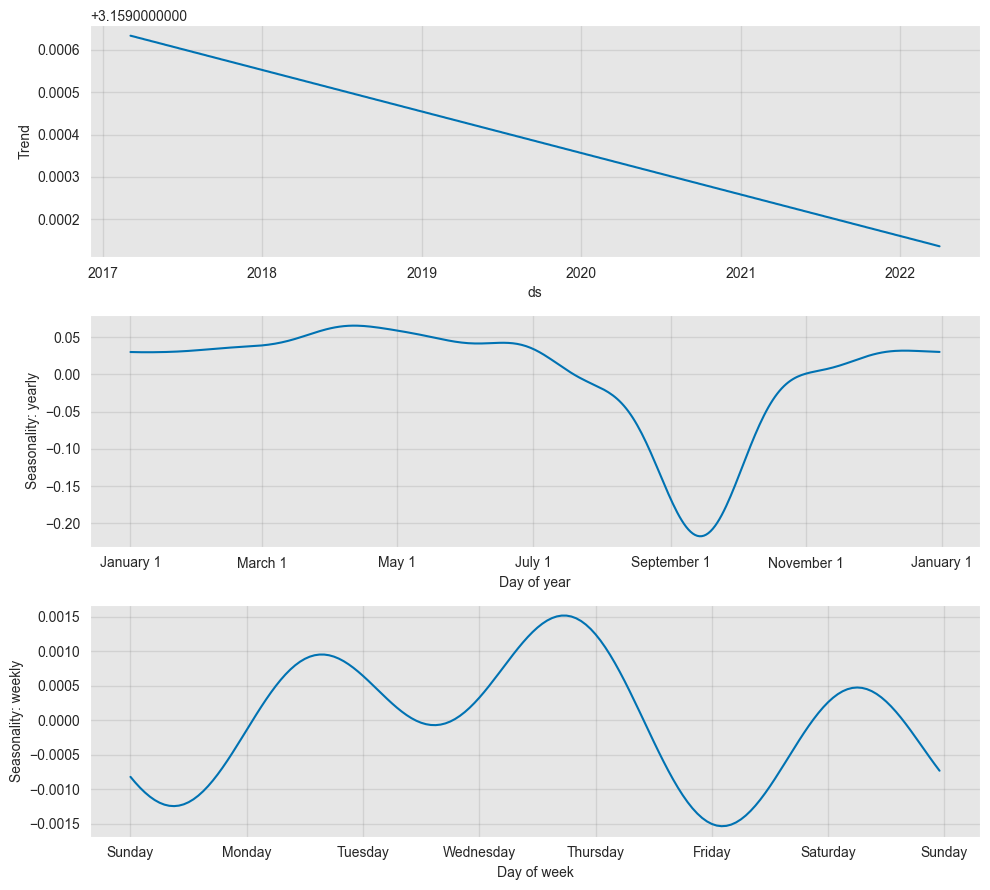

In [96]:
fig2 = m.plot_components(forecast_2)

In [97]:
forecast_2.head(5)

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2017-03-05,3.223471,3.199066,-0.024405,3.159633,0.040254,-0.000822
1,2017-03-06,3.223471,3.200196,-0.023275,3.159633,0.040704,-0.000141
2,2017-03-07,3.223471,3.201469,-0.022002,3.159633,0.041196,0.000641
3,2017-03-08,3.240791,3.201687,-0.039104,3.159632,0.041730,0.000325
4,2017-03-09,3.240356,3.203183,-0.037173,3.159632,0.042308,0.001242


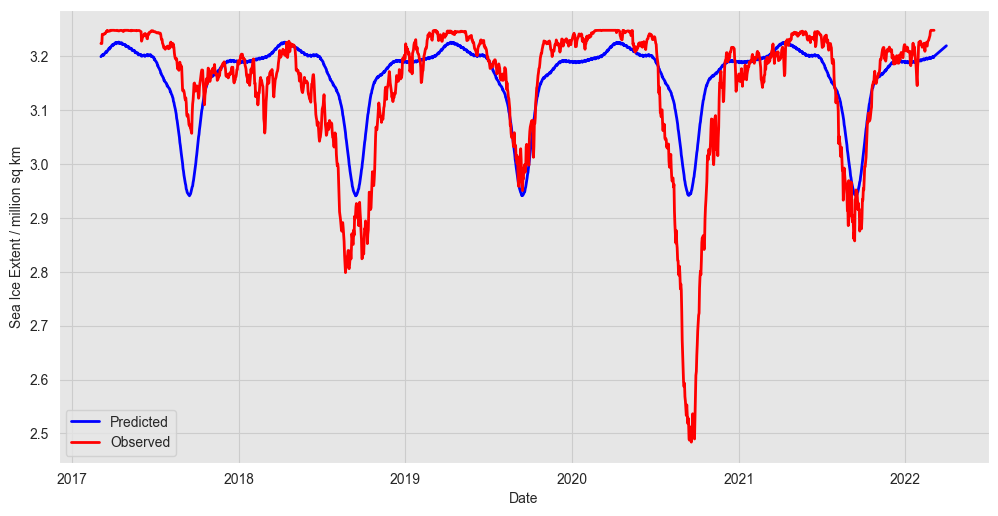

In [105]:
plt.plot(forecast_2['ds'], forecast_2['yhat1'], color='blue', linewidth=2, label='Predicted')
plt.plot(forecast_2['ds'], forecast_2['y'], color='red', linewidth=2, label='Observed')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent / million sq km')
plt.legend()
#plt.xticks(monthList)
#plt.title('Predicted Sea Ice for Central Arctic')

plt.savefig('images/Forecast_CA_1.png', dpi=300)
plt.show()

# Future prediction for the next Season

In [109]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_CA, freq="MS", valid_p=0.23)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.012641,0.060192,0.096313


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



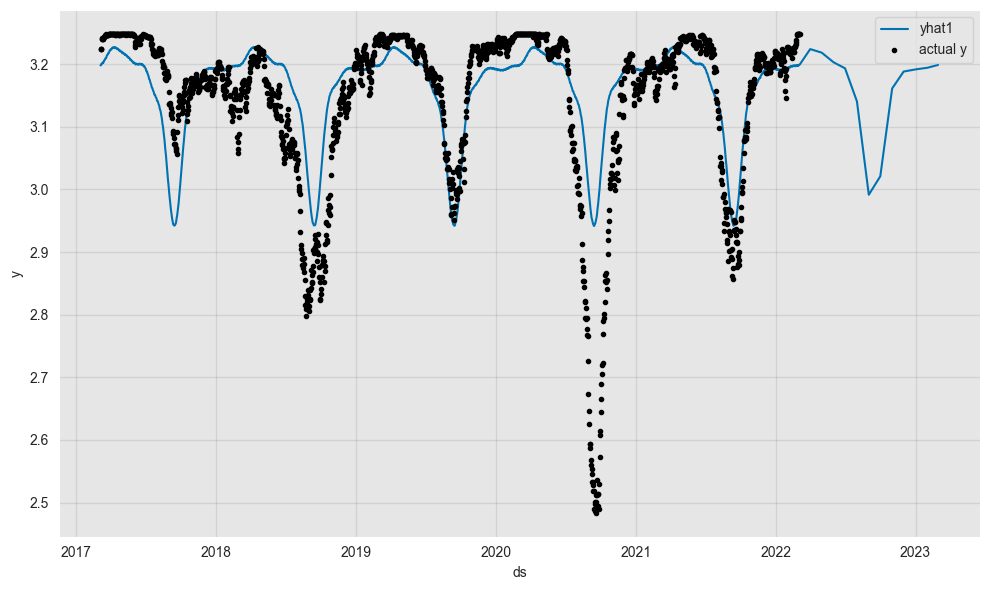

In [110]:
future_CA1 = m.make_future_dataframe(df_CA, periods=12, n_historic_predictions=365*5)
forecast_CA1 = m.predict(future_CA1)
fig = m.plot(forecast_CA1)

In [111]:
df_HB_NextSeason = forecast_CA1[['ds','y','yhat1']]

In [112]:
df_HB_NextSeason.head()

,ds,y,yhat1
0,2017-03-05,3.223471,3.197835
1,2017-03-06,3.223471,3.197900
2,2017-03-07,3.223471,3.199859
3,2017-03-08,3.240791,3.200627
4,2017-03-09,3.240356,3.200393


In [123]:
df_HB_NextSeason['date'] = pd.to_datetime(df_HB_NextSeason['ds'], format='%Y-%m-%d')
# Convert timestamp to datetime object
df_HB_NextSeason = df_HB_NextSeason.assign(
    timestamp = lambda x: pd.to_datetime(x['date']), 
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day
)

WARNING - (py.warnings._showwarnmsg) - /var/folders/7g/k57j6sh92x965dgjckb4b5wm0000gn/T/ipykernel_24401/1314205459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_HB_NextSeason['date'] = pd.to_datetime(df_HB_NextSeason['ds'], format='%Y-%m-%d')



In [124]:
df_HB_NextSeason.head(2)

,ds,y,yhat1,date,timestamp,year,month,day
0,2017-03-05,3.223471,3.197835,2017-03-05,2017-03-05,2017,3,5
1,2017-03-06,3.223471,3.197900,2017-03-06,2017-03-06,2017,3,6


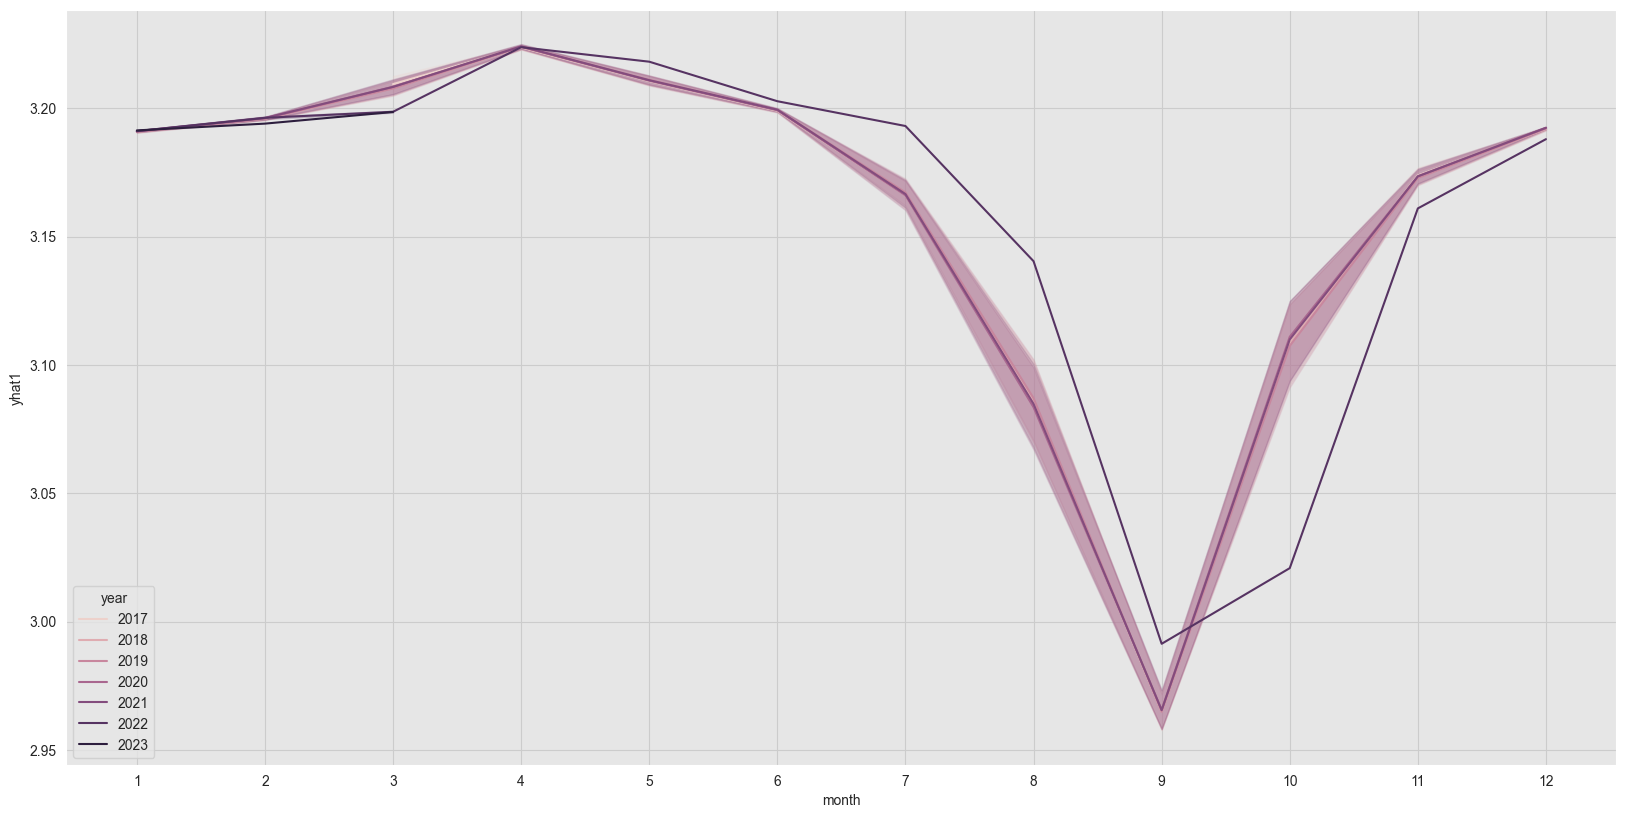

In [131]:
fig, axs = plt.subplots(figsize=(20, 10))

sns.lineplot(x='month', y='yhat1', data=df_HB_NextSeason, hue='year')
#sns.set_palette("pastel")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12]);

In [115]:
# df_HB_NextSeason_1=df_HB_NextSeason[(df_HB_NextSeason['ds']>'2022-01-01') & (df_HB_NextSeason['ds']<'1-2023-01-01')]
# pd.DataFrame(df_HB_NextSeason_1)

## Modelling for Hudson_Bay

In [85]:
df_HB = pd.read_csv('data/Hudson_Bay_from_masie.csv')
df_HB.head(2)

,date,Hudson_Bay
0,01-01-2006,1260715.19
1,01-02-2006,1260715.19


In [86]:
df_HB['Hudson_Bay'] /= 1000000

In [87]:
df_HB.head(2)

,date,Hudson_Bay
0,01-01-2006,1.260715
1,01-02-2006,1.260715


In [88]:
df_HB['date'] = pd.to_datetime(df_HB['date'])

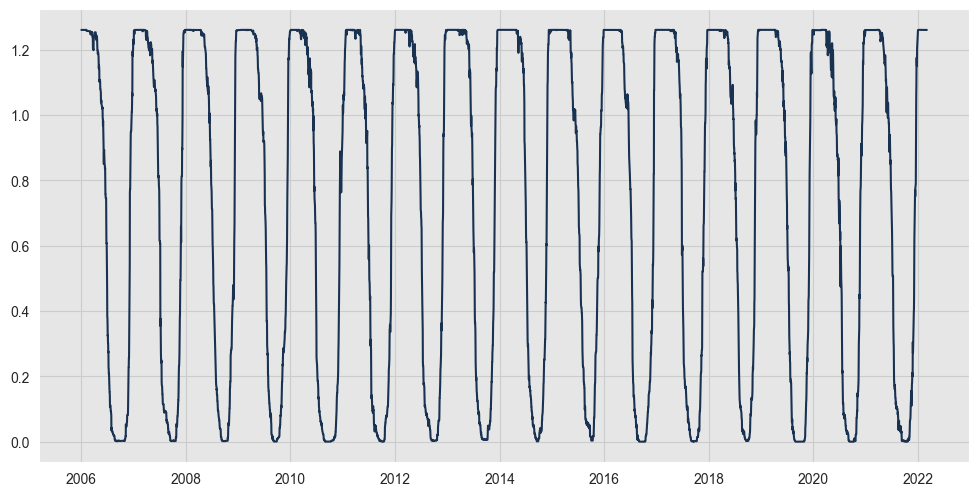

In [89]:
plt.plot(df_HB['date'], df_HB['Hudson_Bay'])
plt.show()

In [90]:
df_HB['date'] = pd.to_datetime(df_HB['date'])
df_HB = df_HB[['date', 'Hudson_Bay']]
df_HB.dropna(inplace=True)
df_HB.columns = ['ds', 'y']

In [91]:
df_HB.head(2)

,ds,y
0,2006-01-01,1.260715
1,2006-01-02,1.260715


In [44]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_HB, freq="MS", valid_p=0.25)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.002569,0.054839,0.090012


In [45]:
df_train

,ds,y
0,2006-01-01,1.260715
1,2006-01-02,1.260715
2,2006-01-03,1.260779
3,2006-01-04,1.260779
4,2006-01-05,1.260779
...,...,...
4394,2018-02-24,1.260838
4395,2018-02-25,1.260838
4396,2018-02-26,1.260838
4397,2018-02-27,1.260838


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



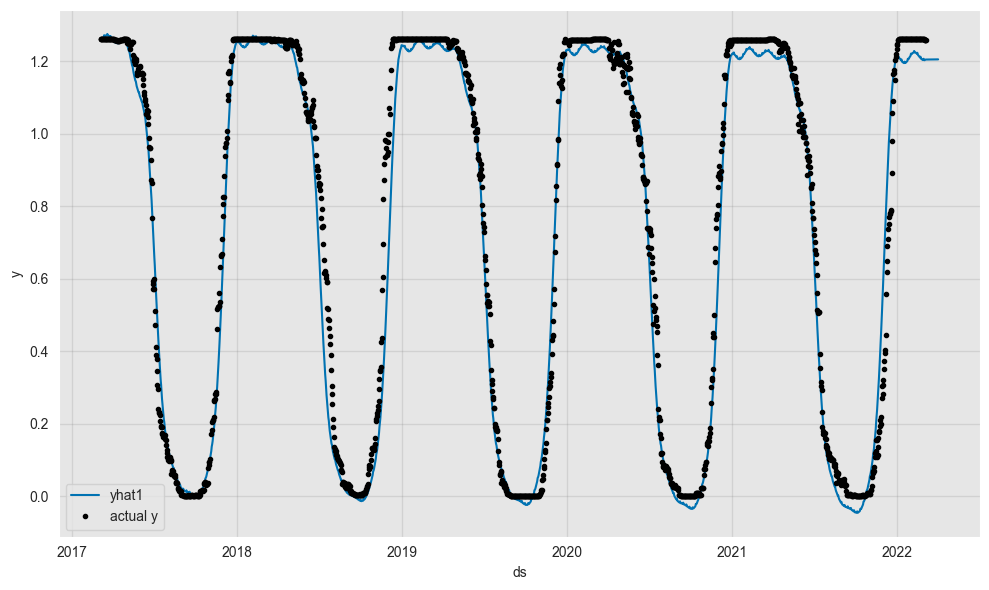

In [46]:
#metrics_train2 = m.fit(df=df_NH, freq="MS")
future = m.make_future_dataframe(df_HB, periods=1, n_historic_predictions=365*5)
forecast = m.predict(future)
fig = m.plot(forecast)

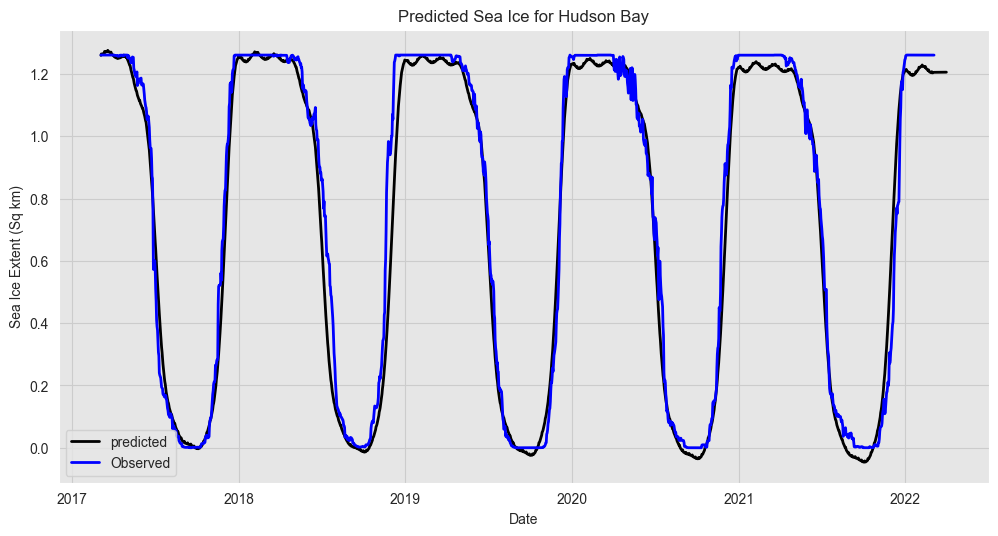

In [50]:
plt.plot(forecast['ds'], forecast['yhat1'], color='black', linewidth=2, label='predicted')
plt.plot(forecast['ds'], forecast['y'], color='blue', linewidth=2, label='Observed')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (Sq km)')
plt.legend()
#plt.xticks(monthList)
plt.title('Predicted Sea Ice for Hudson Bay')

plt.savefig('images/Forecast_HB_1.png', dpi=300)
plt.show()

In [291]:
forecast.head(5)

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,1978-10-26,10.231,9.892876,-0.338124,12.316751,-2.428289,0.004413
1,1978-10-28,10.42,10.078624,-0.341376,12.316762,-2.242588,0.004451
2,1978-10-30,10.557,10.237154,-0.319846,12.316772,-2.066835,-0.012783
3,1978-11-01,10.67,10.410049,-0.259951,12.316782,-1.901931,-0.004802
4,1978-11-03,10.777,10.578141,-0.198859,12.316792,-1.748201,0.009551


# Prediction for the future

In [ ]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_HB, freq="MS", valid_p=0.25)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



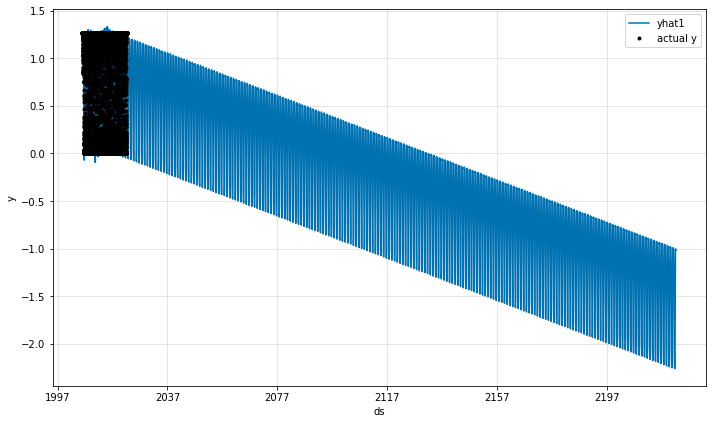

In [189]:
future = m.make_future_dataframe(df_HB, periods=24*100, n_historic_predictions=365*39)
forecast = m.predict(future)
fig = m.plot(forecast)

# Prediction for the next Season

In [92]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_HB, freq="MS", valid_p=0.25)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.002547,0.053559,0.089573


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



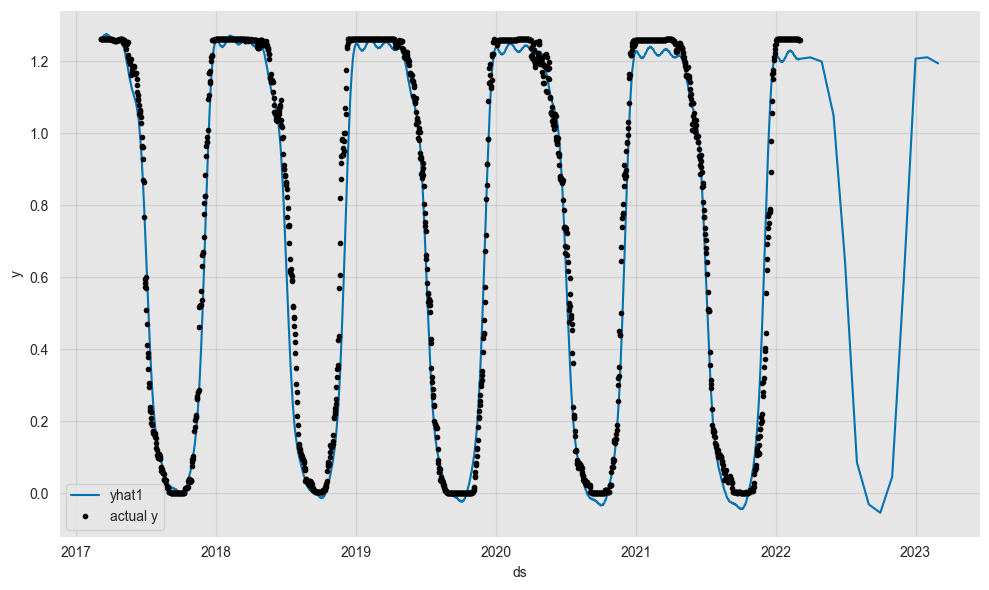

In [93]:
future_HB1 = m.make_future_dataframe(df_HB, periods=12, n_historic_predictions=365*5)
forecast_HB1 = m.predict(future_HB1)
fig = m.plot(forecast_HB1)

## Modelling for Sea of Okhotst

In [94]:
df_SO = pd.read_csv('data/Sea_of_Okhotsk_from_masie.csv')
df_SO.head(2)

,date,Sea_of_Okhotsk
0,01-01-2006,287369.54
1,01-02-2006,287369.54


In [95]:
df_SO['Sea_of_Okhotsk'] /= 1000000

In [96]:
df_SO.head(2)

,date,Sea_of_Okhotsk
0,01-01-2006,0.28737
1,01-02-2006,0.28737


In [97]:
df_SO['date'] = pd.to_datetime(df_SO['date'])

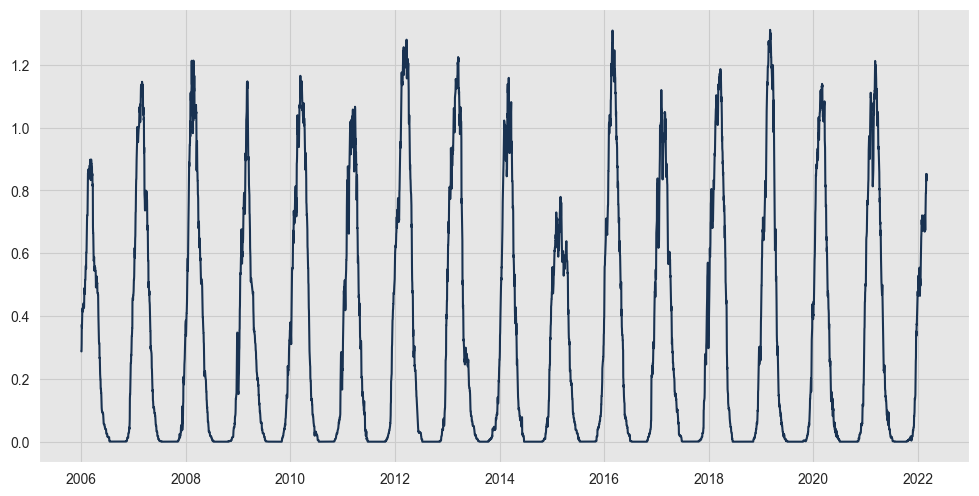

In [98]:
plt.plot(df_SO['date'], df_SO['Sea_of_Okhotsk'])
plt.show()

In [99]:
df_SO['date'] = pd.to_datetime(df_SO['date'])
df_SO = df_SO[['date', 'Sea_of_Okhotsk']]
df_SO.dropna(inplace=True)
df_SO.columns = ['ds', 'y']

In [100]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_SO, freq="MS", valid_p=0.17)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.002994,0.05711,0.08471


In [60]:
df_train

,ds,y
0,2006-01-01,0.287370
1,2006-01-02,0.287370
2,2006-01-03,0.311943
3,2006-01-04,0.372868
4,2006-01-05,0.363515
...,...,...
4863,2019-06-08,0.016373
4864,2019-06-09,0.023805
4865,2019-06-10,0.024719
4866,2019-06-11,0.023438


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



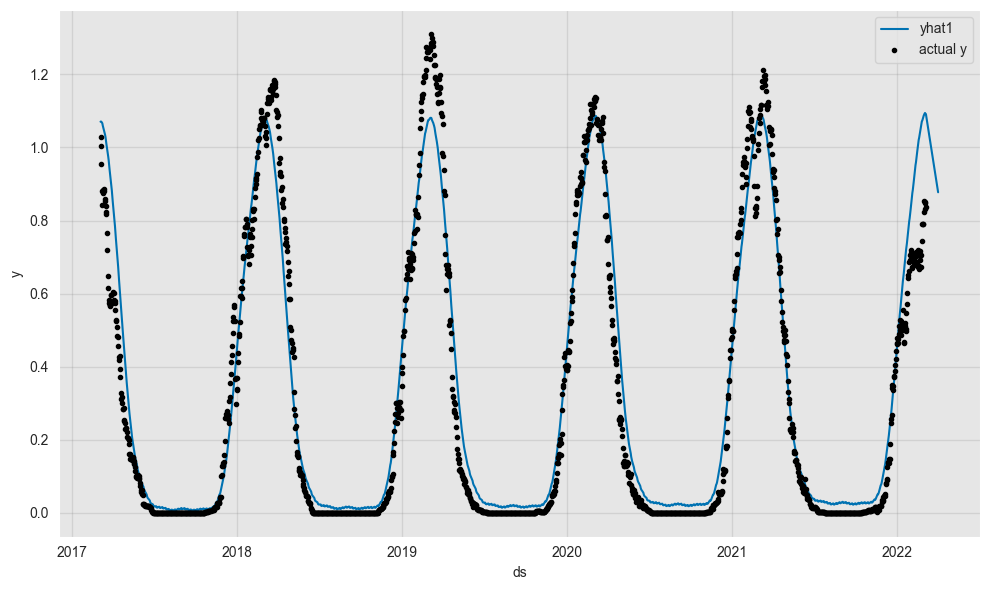

In [101]:
#metrics_train2 = m.fit(df=df_NH, freq="MS")
future_SO = m.make_future_dataframe(df_SO, periods=1, n_historic_predictions=365*5)
forecast_SO = m.predict(future_SO)
fig = m.plot(forecast_SO)

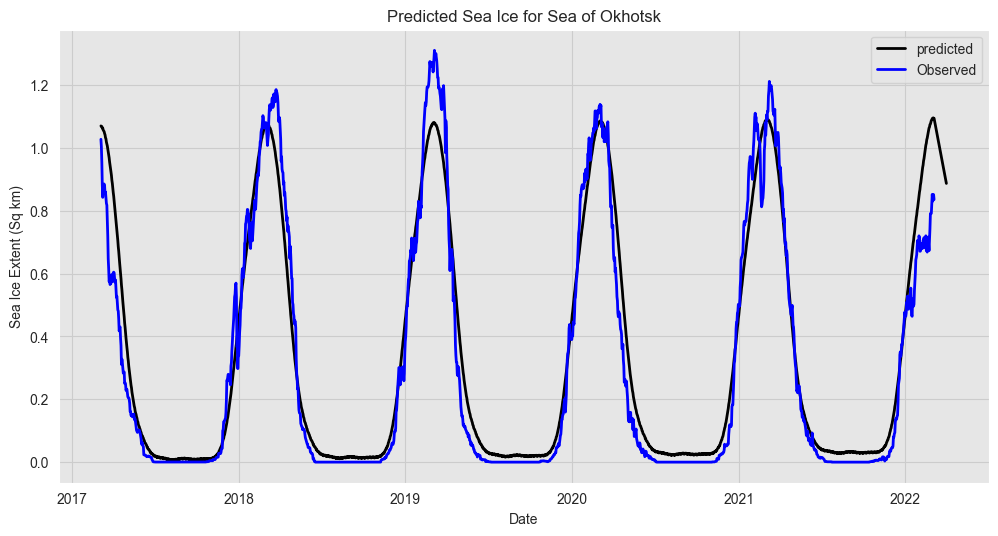

In [67]:
plt.plot(forecast_SO['ds'], forecast_SO['yhat1'], color='black', linewidth=2, label='predicted')
plt.plot(forecast_SO['ds'], forecast_SO['y'], color='blue', linewidth=2, label='Observed')
plt.xlabel('Date')
plt.ylabel('Sea Ice Extent (Sq km)')
plt.legend()
#plt.xticks(monthList)
plt.title('Predicted Sea Ice for Sea of Okhotsk')

plt.savefig('images/Forecast_SO_1.png', dpi=300)
plt.show()

# Prediction for the next Season

In [102]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_SO, freq="MS", valid_p=0.17)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.003049,0.058811,0.085478


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



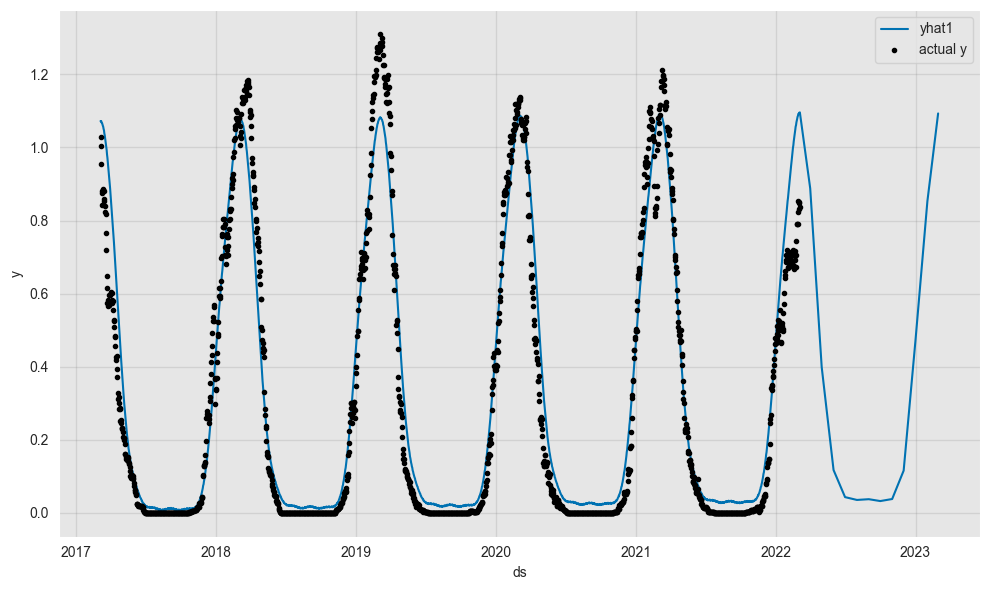

In [103]:
future_SO1 = m.make_future_dataframe(df_SO, periods=12, n_historic_predictions=365*5)
forecast_SO1 = m.predict(future_SO1)
fig = m.plot(forecast_SO1)

In [104]:
forecast_SO1

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly
0,2017-03-05,1.027656,1.072361,0.044705,0.312907,0.758697,0.000757
1,2017-03-06,1.003611,1.071102,0.067491,0.312921,0.758424,-0.000242
2,2017-03-07,0.953551,1.071874,0.118322,0.312934,0.757482,0.001457
3,2017-03-08,0.880748,1.067537,0.186789,0.312948,0.755872,-0.001283
4,2017-03-09,0.842842,1.066965,0.224123,0.312962,0.753597,0.000406
...,...,...,...,...,...,...,...
1832,2022-11-01,None,0.037682,NaN,0.341109,-0.304885,0.001457
1833,2022-12-01,None,0.115428,NaN,0.341518,-0.226496,0.000406
1834,2023-01-01,None,0.473260,NaN,0.341941,0.130562,0.000757
1835,2023-02-01,None,0.853097,NaN,0.342364,0.512015,-0.001283


# Prediction for the future

In [62]:
m = NeuralProphet(yearly_seasonality=8, seasonality_mode= "additive", learning_rate = 0.1)
df_train, df_test = m.split_df(df=df_SO, freq="MS", valid_p=0.17)

metrics_train = m.fit(df_train, freq="MS")
metrics_test = m.test(df_test)

metrics_test

,SmoothL1Loss,MAE,RMSE
0,0.003085,0.059121,0.085982


WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1665: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - /Users/aanysofia/neuefische/ice_cream/.venv/lib/python3.9/site-packages/neuralprophet/forecaster.py:1068: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



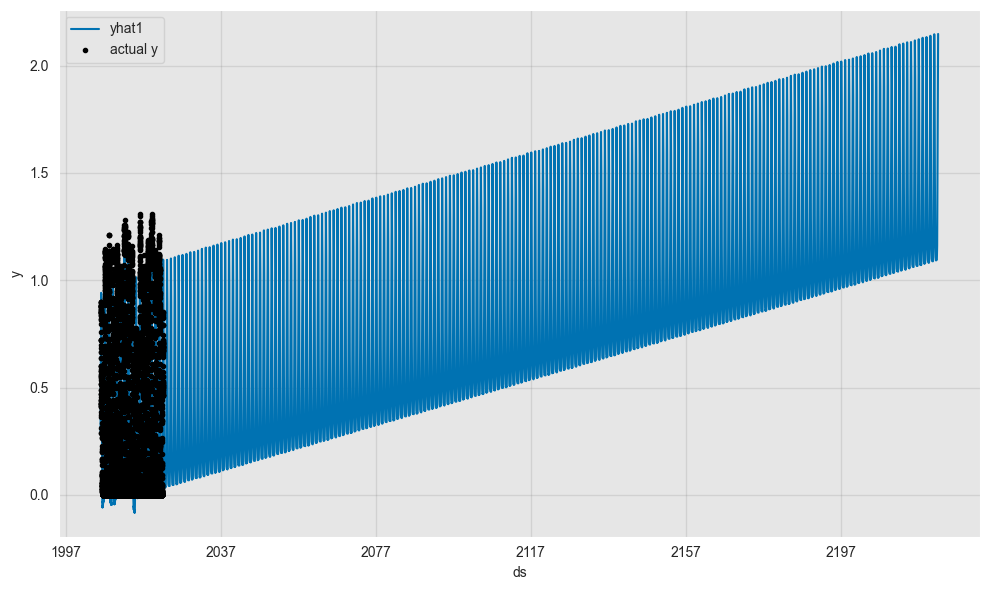

In [63]:
future = m.make_future_dataframe(df_SO, periods=24*100, n_historic_predictions=365*39)
forecast = m.predict(future)
fig = m.plot(forecast)